# Final Project: Deriving Tables & PCA model

    Course:   DS 5001
    Author:   Elizabeth Burrell
    Date:     April 2024

## Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly_express as px
from glob import glob
import re
import nltk

C:\Users\Student\anaconda3\lib\site-packages\scipy\__init__.py:173: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from scipy.linalg import norm, eigh
from sklearn.decomposition import PCA

In [3]:
from numpy.linalg import norm
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

In [3]:
sns.set()

In [4]:
sns.set(style='ticks')

In [5]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home'] 
output_dir = config['DEFAULT']['output_dir']
data_prefix = 'gothic-texts'
out_path = f'{output_dir}/{data_prefix}'

In [6]:
OHCO = ['book_id','chap_id','para_num', 'sent_num', 'token_num']
bags = dict(
    SENTS = OHCO[:4],
    PARAS = OHCO[:3],
    CHAPS = OHCO[:2],
    BOOKS = OHCO[:1]
)

In [7]:
LIB = pd.read_csv(f"{output_dir}/{data_prefix}-LIB.csv").set_index('book_id')
CORPUS = pd.read_csv(f'{output_dir}/{data_prefix}-CORPUS.csv').set_index(OHCO).dropna()

In [8]:
VOCAB = pd.read_csv(f'{output_dir}/{data_prefix}-VOCAB.csv').set_index('term_str')

## Creating BOW representation of CORPUS

In [9]:
def generate_BOW(CORPUS, bag):
    
    BOW = CORPUS.groupby(bags[bag]+['term_str']).term_str.count().to_frame('n')

    return BOW

In [10]:
# creating BOW with chapters as the bag
chaps = generate_BOW(CORPUS, 'CHAPS')

In [11]:
chaps

n
book_id chap_id term_str   
345     1       13000     1
                1st       1
                3         1
                4         1
                5         1
...                      ..
4078    40      yielded   1
                you       1
                young     2
                your      1
                youth     6

[125153 rows x 1 columns]

In [56]:
chaps['tfidf'] = TFIDF.stack()

In [57]:
chaps

n     tfidf
book_id chap_id term_str             
345     1       13000     1  0.016200
                1st       1  0.016200
                3         1  0.008117
                4         1  0.007783
                5         1  0.009369
...                      ..       ...
4078    40      yielded   1  0.033700
                you       1  0.000291
                young     2  0.006794
                your      1  0.000589
                youth     6  0.112173

[125153 rows x 2 columns]

In [58]:
chaps.to_csv(f'{out_path}-BOW.csv')

## DTM
    Creating represenation of the BOW as a sparse count matrix.

In [13]:
DTCM = chaps.n.unstack(fill_value=0)

In [14]:
DTCM

term_str         1  10  100  1000  1018  1030  10s  10th  11  1100  ...  \
book_id chap_id                                                     ...   
345     1        0   0    0     0     0     0    0     0   0     0  ...   
        2        0   0    0     0     0     0    0     0   0     0  ...   
        3        0   0    0     0     0     0    0     0   0     0  ...   
        4        0   0    0     0     0     0    0     0   0     0  ...   
        5        0   0    0     0     0     0    0     0   0     0  ...   
...             ..  ..  ...   ...   ...   ...  ...   ...  ..   ...  ...   
4078    36       0   0    0     0     0     0    0     0   0     0  ...   
        37       0   0    0     0     0     0    0     0   0     0  ...   
        38       0   0    0     0     0     0    0     0   0     0  ...   
        39       0   0    0     0     0     0    0     0   0     0  ...   
        40       0   0    0     0     0     0    0     0   0     0  ...   

term_str         zoology  zoölogical  zoöphagous  zoöphagy  zêle  à  æt  ætat  \
book_id chap_id                                                                 
345     1              0           0           0         0     0  0   0     0   
        2              0           0           0         0     0  0   0     0   
        3              0           0           0         0     0  0   0     0   
        4              0           0           0         0     0  0   0     0   
        5              0           0           0         0     0  0   0     1   
...                  ...         ...         ...       ...   ... ..  ..   ...   
4078    36             0           0           0         0     0  0   0     0   
        37             0           0           0         0     0  0   0     0   
        38             0           0           0         0     0  0   0     0   
        39             0           0           0         0     0  0   0     0   
        40             0           0           0         0     0  0   0     0   

term_str         édition  émaux  
book_id chap_id                  
345     1              0      0  
        2              0      0  
        3              0      0  
        4              0      0  
        5              0      0  
...                  ...    ...  
4078    36             0      0  
        37             0      0  
        38             0      0  
        39             0      0  
        40             0      0  

[101 rows x 19990 columns]

In [59]:
DTCM.to_csv(f'{out_path}-DTM.csv')

## TFIDF
    A Document-Term matrix with TFIDF values.

In [15]:
def calculate_tf(BOW, tf_method):
   
    DTCM = BOW.n.unstack(fill_value=0)
    
    if tf_method == 'sum':
        TF = DTCM.T / DTCM.T.sum()

    elif tf_method == 'max':
        TF = DTCM.T / DTCM.T.max()
    
    TF = TF.T
    
    DF = DTCM.astype('bool').sum() 
    
    N = DTCM.shape[0]
    
    IDF = np.log2(N / DF)
    
    TFIDF = TF * IDF
    
    return TFIDF

In [16]:
TFIDF = calculate_tf(chaps, 'max')

In [17]:
TFIDF

term_str           1   10  100  1000  1018  1030  10s  10th   11  1100  ...  \
book_id chap_id                                                         ...   
345     1        0.0  0.0  0.0   0.0   0.0   0.0  0.0   0.0  0.0   0.0  ...   
        2        0.0  0.0  0.0   0.0   0.0   0.0  0.0   0.0  0.0   0.0  ...   
        3        0.0  0.0  0.0   0.0   0.0   0.0  0.0   0.0  0.0   0.0  ...   
        4        0.0  0.0  0.0   0.0   0.0   0.0  0.0   0.0  0.0   0.0  ...   
        5        0.0  0.0  0.0   0.0   0.0   0.0  0.0   0.0  0.0   0.0  ...   
...              ...  ...  ...   ...   ...   ...  ...   ...  ...   ...  ...   
4078    36       0.0  0.0  0.0   0.0   0.0   0.0  0.0   0.0  0.0   0.0  ...   
        37       0.0  0.0  0.0   0.0   0.0   0.0  0.0   0.0  0.0   0.0  ...   
        38       0.0  0.0  0.0   0.0   0.0   0.0  0.0   0.0  0.0   0.0  ...   
        39       0.0  0.0  0.0   0.0   0.0   0.0  0.0   0.0  0.0   0.0  ...   
        40       0.0  0.0  0.0   0.0   0.0   0.0  0.0   0.0  0.0   0.0  ...   

term_str         zoology  zoölogical  zoöphagous  zoöphagy  zêle    à   æt  \
book_id chap_id                                                              
345     1            0.0         0.0         0.0       0.0   0.0  0.0  0.0   
        2            0.0         0.0         0.0       0.0   0.0  0.0  0.0   
        3            0.0         0.0         0.0       0.0   0.0  0.0  0.0   
        4            0.0         0.0         0.0       0.0   0.0  0.0  0.0   
        5            0.0         0.0         0.0       0.0   0.0  0.0  0.0   
...                  ...         ...         ...       ...   ...  ...  ...   
4078    36           0.0         0.0         0.0       0.0   0.0  0.0  0.0   
        37           0.0         0.0         0.0       0.0   0.0  0.0  0.0   
        38           0.0         0.0         0.0       0.0   0.0  0.0  0.0   
        39           0.0         0.0         0.0       0.0   0.0  0.0  0.0   
        40           0.0         0.0         0.0       0.0   0.0  0.0  0.0   

term_str            ætat  édition  émaux  
book_id chap_id                           
345     1        0.00000      0.0    0.0  
        2        0.00000      0.0    0.0  
        3        0.00000      0.0    0.0  
        4        0.00000      0.0    0.0  
        5        0.03599      0.0    0.0  
...                  ...      ...    ...  
4078    36       0.00000      0.0    0.0  
        37       0.00000      0.0    0.0  
        38       0.00000      0.0    0.0  
        39       0.00000      0.0    0.0  
        40       0.00000      0.0    0.0  

[101 rows x 19990 columns]

In [60]:
TFIDF.to_csv(f'{out_path}-TFIDF.csv')

In [18]:
VOCAB['mean_TFIDF'] = TFIDF.mean()

In [19]:
VOCAB

,n,n_chars,p,i,max_pos,max_pos_group,stop,stem_porter,dfidf,mean_TFIDF
term_str,,,,,,,,,,
1,16,1,0.000031,14.995464,JJ,JJ,0,1,31.394578,0.001782
10,7,2,0.000013,16.188109,JJ,JJ,0,10,24.439494,0.000831
100,3,3,0.000006,17.410501,CD,CD,0,100,6.658211,0.000040
1000,8,4,0.000015,15.995464,CD,CD,0,1000,6.658211,0.000105
1018,1,4,0.000002,18.995464,CD,CD,0,1018,6.658211,0.000237
...,...,...,...,...,...,...,...,...,...,...
à,4,1,0.000008,16.995464,NN,NN,0,à,18.632846,0.001115
æt,1,2,0.000002,18.995464,NN,NN,0,æt,6.658211,0.000241
ætat,1,4,0.000002,18.995464,NNP,NN,0,ætat,6.658211,0.000356


In [20]:
VIDX = VOCAB.sort_values('dfidf', ascending=False).head(1000).index

## Reduced and Normalized TFIDF_L2
    A Document-Term matrix with L2 normalized TFIDF values.

In [21]:
reducedTFIDF = TFIDF[VIDX].fillna(0).groupby(OHCO[:1]).mean()

In [22]:
reducedTFIDF

term_str,wonderful,reach,promise,serious,brain,street,telling,creature,seized,son,...,watch,point,grew,wont,strong,stretched,importance,dorian,produced,professor
book_id,,,,,,,,,,,,,,,,,,,,,
345,0.005269,0.002194,0.006861,0.002056,0.010871,0.002698,0.004916,0.001443,0.002164,0.002303,...,0.005972,0.002993,0.004981,0.001949,0.006568,0.000876,0.001870,0.000000,0.002035,0.046921
768,0.000193,0.005911,0.005032,0.003167,0.002033,0.000227,0.002005,0.005189,0.006435,0.012915,...,0.003017,0.002732,0.005466,0.012727,0.004347,0.004053,0.000000,0.000000,0.003697,0.000000
1661,0.001756,0.003656,0.003339,0.005367,0.000289,0.037643,0.003911,0.002190,0.006182,0.003328,...,0.006322,0.007543,0.000495,0.002568,0.005418,0.006102,0.016872,0.000000,0.000233,0.000000
3070,0.001143,0.004547,0.004116,0.003977,0.000334,0.016116,0.002626,0.007050,0.000887,0.001737,...,0.001927,0.006155,0.000742,0.000715,0.003684,0.002240,0.009392,0.000000,0.000000,0.000000
4078,0.021098,0.000543,0.001919,0.009034,0.006687,0.008507,0.005634,0.003475,0.002617,0.008558,...,0.003681,0.005901,0.003980,0.007698,0.001754,0.003818,0.002889,0.274616,0.003509,0.000494


In [23]:
L0 = reducedTFIDF.astype('bool').astype('int') # Binary (Pseudo L)
L1 = reducedTFIDF.apply(lambda x: x / x.sum(), 1) # Probabilistic
L2 = reducedTFIDF.apply(lambda x: x / norm(x), 1) # Pythagorean, AKA Euclidean

In [24]:
L2

term_str,wonderful,reach,promise,serious,brain,street,telling,creature,seized,son,...,watch,point,grew,wont,strong,stretched,importance,dorian,produced,professor
book_id,,,,,,,,,,,,,,,,,,,,,
345,0.029099,0.012116,0.037890,0.011354,0.060031,0.014898,0.027148,0.007968,0.011948,0.012716,...,0.032980,0.016530,0.027504,0.010763,0.036271,0.004836,0.010326,0.000000,0.011237,0.259109
768,0.000631,0.019337,0.016464,0.010362,0.006650,0.000742,0.006558,0.016978,0.021052,0.042254,...,0.009871,0.008937,0.017883,0.041639,0.014221,0.013260,0.000000,0.000000,0.012095,0.000000
1661,0.011121,0.023158,0.021150,0.033995,0.001833,0.238428,0.024774,0.013870,0.039158,0.021080,...,0.040046,0.047778,0.003133,0.016263,0.034318,0.038648,0.106866,0.000000,0.001478,0.000000
3070,0.006296,0.025037,0.022660,0.021896,0.001840,0.088733,0.014461,0.038815,0.004884,0.009566,...,0.010609,0.033891,0.004087,0.003939,0.020282,0.012332,0.051714,0.000000,0.000000,0.000000
4078,0.058543,0.001507,0.005325,0.025068,0.018555,0.023606,0.015634,0.009641,0.007260,0.023746,...,0.010215,0.016374,0.011044,0.021360,0.004868,0.010593,0.008017,0.762006,0.009737,0.001372


In [61]:
L2.to_csv(f'{out_path}-TFIDF_L2.csv')

## Applying PCA to CORPUS

### filtering for nouns in VOCAB

In [66]:
part_pos = ["NN","NNS"]

In [67]:
VIDX = VOCAB.loc[VOCAB.max_pos.isin(part_pos)]\
    .sort_values('dfidf', ascending=False)\
    .head(1000).index

In [69]:
tfidf = TFIDF.filter(VIDX, axis=1)

In [70]:
tfidf

term_str         creature      view     brain     women   promise       son  \
book_id chap_id                                                               
345     1        0.000000  0.000000  0.000000  0.003525  0.000000  0.000000   
        2        0.000000  0.009287  0.000000  0.004643  0.000000  0.000000   
        3        0.004128  0.004128  0.008255  0.016510  0.004128  0.000000   
        4        0.003525  0.000000  0.003525  0.017625  0.000000  0.000000   
        5        0.000000  0.007831  0.000000  0.046987  0.007831  0.000000   
...                   ...       ...       ...       ...       ...       ...   
4078    36       0.000000  0.000000  0.023750  0.063334  0.000000  0.000000   
        37       0.000000  0.000000  0.000000  0.111443  0.000000  0.000000   
        38       0.000000  0.000000  0.006965  0.006965  0.000000  0.000000   
        39       0.000000  0.011408  0.011408  0.000000  0.011408  0.011408   
        40       0.000000  0.000000  0.000000  0.000000  0.014634  0.000000   

term_str           throat    beauty     study  appearance  ...  stake  \
book_id chap_id                                            ...          
345     1        0.000000  0.006863  0.000000    0.000000  ...    0.0   
        2        0.004520  0.004520  0.004520    0.000000  ...    0.0   
        3        0.012054  0.004018  0.000000    0.000000  ...    0.0   
        4        0.000000  0.000000  0.003431    0.000000  ...    0.0   
        5        0.000000  0.000000  0.022869    0.000000  ...    0.0   
...                   ...       ...       ...         ...  ...    ...   
4078    36       0.015413  0.000000  0.000000    0.000000  ...    0.0   
        37       0.000000  0.036161  0.000000    0.000000  ...    0.0   
        38       0.000000  0.000000  0.000000    0.000000  ...    0.0   
        39       0.000000  0.000000  0.000000    0.011105  ...    0.0   
        40       0.014245  0.071226  0.000000    0.000000  ...    0.0   

term_str         blessing  tender   blazing  heartily    weapon   liberty  \
book_id chap_id                                                             
345     1        0.007783     0.0  0.000000       0.0  0.000000  0.000000   
        2        0.000000     0.0  0.000000       0.0  0.000000  0.000000   
        3        0.000000     0.0  0.018227       0.0  0.000000  0.009113   
        4        0.000000     0.0  0.000000       0.0  0.023349  0.000000   
        5        0.000000     0.0  0.000000       0.0  0.000000  0.000000   
...                   ...     ...       ...       ...       ...       ...   
4078    36       0.000000     0.0  0.000000       0.0  0.000000  0.000000   
        37       0.000000     0.0  0.000000       0.0  0.000000  0.000000   
        38       0.000000     0.0  0.000000       0.0  0.000000  0.015379   
        39       0.025187     0.0  0.000000       0.0  0.000000  0.000000   
        40       0.000000     0.0  0.000000       0.0  0.000000  0.000000   

term_str         pony  indignation  tomb  
book_id chap_id                           
345     1         0.0     0.000000   0.0  
        2         0.0     0.000000   0.0  
        3         0.0     0.000000   0.0  
        4         0.0     0.000000   0.0  
        5         0.0     0.000000   0.0  
...               ...          ...   ...  
4078    36        0.0     0.000000   0.0  
        37        0.0     0.000000   0.0  
        38        0.0     0.000000   0.0  
        39        0.0     0.000000   0.0  
        40        0.0     0.032311   0.0  

[101 rows x 1000 columns]

## Compute PCA

In [71]:
def get_pca(TFIDF, 
            k=10, 
            norm_docs=True,
            norm_level=2,
            center_by_mean=True, 
            center_by_variance=False):
    
    # if TFIDF.isna().sum().sum():
    #     print("Filled NA")
    #     TFIDF = TFIDF.fillna(0)
    
    if norm_docs:
        # TFIDF = TFIDF.apply(lambda x: x / norm(x), 1).fillna(0)
        TFIDF = (TFIDF.T / norm(TFIDF, 2, axis=1)).T
    
    if center_by_mean:
        TFIDF = TFIDF - TFIDF.mean()
        
    if center_by_variance:
        TFIDF = TFIDF / TFIDF.std()        

    COV = TFIDF.cov()

    eig_vals, eig_vecs = eigh(COV)
    
    EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
    EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
    EIG_VAL.index.name = 'term_str'
        
    EIG_IDX = EIG_VAL.eig_val.sort_values(ascending=False).head(k)
    
    COMPS = EIG_VEC[EIG_IDX.index].T
    COMPS.index = [i for i in range(COMPS.shape[0])]
    COMPS.index.name = 'pc_id'
    

    LOADINGS = COMPS.T

    DCM = TFIDF.dot(LOADINGS)
    
    COMPINF = pd.DataFrame(index=COMPS.index)

    for i in range(k):
        for j in [0, 1]:
            top_terms = ' '.join(LOADINGS.sort_values(i, ascending=bool(j)).head(5).index.to_list())
            COMPINF.loc[i, j] = top_terms
    COMPINF = COMPINF.rename(columns={0:'pos', 1:'neg'})
    
    COMPINF['eig_val'] = EIG_IDX.reset_index(drop=True).to_frame()
    COMPINF['exp_var'] = COMPINF.eig_val / COMPINF.eig_val.sum()
    
    return LOADINGS, DCM, COMPINF

In [72]:
bag = OHCO[:2] # chapter
max_terms = 1000
tf_method = 'max'
global_term_sig = 'dfidf'
n_comps = 10
center_by_mean=False
center_by_variance=False

In [73]:
center_by_mean, center_by_variance

(False, False)

In [74]:
LOADINGS, DCM, COMPINF = get_pca(tfidf, 
                                 norm_docs=True, 
                                 norm_level=2, 
                                 center_by_mean=center_by_mean, 
                                 center_by_variance=center_by_variance)

## LOADINGS

In [103]:
LOADINGS = LOADINGS.sort_index()
LOADINGS

pc_id,0,1,2,3,4,5,6,7,8,9
term_str,,,,,,,,,,
absence,0.047161,0.012479,0.015119,-0.015893,-0.009818,-0.010554,-0.042122,0.007660,0.017212,-0.011565
accident,-0.001770,-0.018061,-0.001298,0.006410,0.003597,-0.009710,0.006215,-0.008443,0.011547,-0.019584
accord,0.001872,-0.001692,-0.004304,-0.010363,-0.019621,-0.030965,0.003621,-0.007007,0.019943,-0.060199
account,0.017886,0.007921,-0.007139,-0.030078,0.011486,-0.017364,-0.008880,-0.000195,-0.012905,0.020535
acquaintance,0.016820,0.025332,0.029749,-0.012120,0.025270,-0.032084,-0.030549,0.015597,0.023087,-0.032190
...,...,...,...,...,...,...,...,...,...,...
youll,0.155599,0.013128,0.012267,-0.022766,-0.027810,-0.006293,-0.050967,-0.020241,0.002426,0.028208
youre,0.078209,0.006237,0.004474,-0.059108,-0.035791,-0.020393,-0.041276,0.030302,0.045683,0.009157
yours,0.009195,-0.005284,-0.008463,-0.036182,0.018078,-0.025826,-0.002945,-0.003142,0.004109,0.017717


In [106]:
LOADINGS.to_csv(f'{out_path}-LOADINGS.csv')

## DCM

In [76]:
DCM

pc_id                   0         1         2         3         4         5  \
book_id chap_id                                                               
345     1       -0.057903  0.034278 -0.164361  0.151911  0.023084 -0.026776   
        2       -0.024986 -0.033061 -0.221423  0.126929 -0.030353 -0.244020   
        3       -0.104610 -0.055678 -0.292577  0.090370 -0.119680 -0.203441   
        4       -0.123009 -0.054763 -0.312081  0.117354 -0.098523 -0.199624   
        5       -0.070911 -0.102040 -0.048281 -0.156096  0.129452 -0.027918   
...                   ...       ...       ...       ...       ...       ...   
4078    36      -0.121012 -0.156818  0.077942  0.179235 -0.084153 -0.091752   
        37      -0.100140 -0.223831  0.125922 -0.027454  0.092665 -0.031346   
        38      -0.079078 -0.104191  0.064368  0.078802 -0.017060 -0.076196   
        39      -0.143586 -0.232777  0.211155 -0.038991  0.073521 -0.024619   
        40      -0.140158 -0.297479  0.301971  0.119139 -0.162138 -0.076170   

pc_id                   6         7         8         9  
book_id chap_id                                          
345     1        0.193146  0.355402 -0.019646 -0.147689  
        2        0.184626  0.253299  0.155279 -0.001238  
        3        0.166647  0.094021  0.209769  0.085232  
        4        0.173405  0.168094  0.208014  0.241666  
        5        0.049650 -0.131608  0.117407 -0.043115  
...                   ...       ...       ...       ...  
4078    36       0.120272  0.230310  0.060430  0.003929  
        37       0.033137 -0.120650  0.095672 -0.115682  
        38       0.004890  0.097926  0.069279  0.006034  
        39      -0.108804 -0.080053  0.121899 -0.019244  
        40      -0.069710 -0.000599  0.082342  0.272884  

[101 rows x 10 columns]

In [108]:
DCM.to_csv(f'{out_path}-DCM.csv')

## COMPINF

In [77]:
COMPINF

,pos,neg,eig_val,exp_var
pc_id,,,,
0,t cousin hes father kitchen,moor hound art portrait women,0.048779,0.190419
1,moor hound baronet hall hill,art portrait picture women beauty,0.043568,0.170076
2,portrait moor picture art beauty,whilst ship sleep boxes castle,0.036008,0.140563
3,t ye snow o moor,uncle father cousin mother son,0.022902,0.089402
4,ye t hotel address cab,coffin moor tomb picture sleep,0.021079,0.082286
5,ship cousin uncle fog sea,window address t bed mistress,0.018532,0.072342
6,uncle mother ye cousin sleep,ship coffin mistress fog tomb,0.017423,0.068016
7,driver castle horses lamp fog,t art ye moor flowers,0.016868,0.065847
8,boxes ship box whilst moor,coffin tomb churchyard hotel stake,0.016267,0.063500


In [107]:
COMPINF.to_csv(f'{out_path}-COMPONENTS.csv')

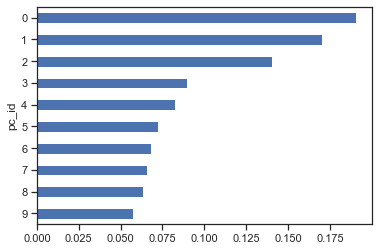

In [78]:
COMPINF.exp_var.sort_values().plot.barh();

## Creating DOC

In [79]:
DOC = pd.DataFrame(index=TFIDF.index).join(LIB)

In [80]:
DOC

source_file_path  \
book_id chap_id                                                      
345     1        C:\Users\Student\Desktop\DS5001\data\gothic\ST...   
        2        C:\Users\Student\Desktop\DS5001\data\gothic\ST...   
        3        C:\Users\Student\Desktop\DS5001\data\gothic\ST...   
        4        C:\Users\Student\Desktop\DS5001\data\gothic\ST...   
        5        C:\Users\Student\Desktop\DS5001\data\gothic\ST...   
...                                                            ...   
4078    36       C:\Users\Student\Desktop\DS5001\data\gothic\WI...   
        37       C:\Users\Student\Desktop\DS5001\data\gothic\WI...   
        38       C:\Users\Student\Desktop\DS5001\data\gothic\WI...   
        39       C:\Users\Student\Desktop\DS5001\data\gothic\WI...   
        40       C:\Users\Student\Desktop\DS5001\data\gothic\WI...   

                       author                       title  \
book_id chap_id                                             
345     1        STOKER, BRAM                     DRACULA   
        2        STOKER, BRAM                     DRACULA   
        3        STOKER, BRAM                     DRACULA   
        4        STOKER, BRAM                     DRACULA   
        5        STOKER, BRAM                     DRACULA   
...                       ...                         ...   
4078    36       WILDE, OSCAR  THE PICTURE OF DORIAN GRAY   
        37       WILDE, OSCAR  THE PICTURE OF DORIAN GRAY   
        38       WILDE, OSCAR  THE PICTURE OF DORIAN GRAY   
        39       WILDE, OSCAR  THE PICTURE OF DORIAN GRAY   
        40       WILDE, OSCAR  THE PICTURE OF DORIAN GRAY   

                                         chap_regex  book_len  n_chaps  \
book_id chap_id                                                          
345     1        (?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$    162859       27   
        2        (?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$    162859       27   
        3        (?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$    162859       27   
        4        (?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$    162859       27   
        5        (?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$    162859       27   
...                                             ...       ...      ...   
4078    36       (?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$     79446       21   
        37       (?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$     79446       21   
        38       (?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$     79446       21   
        39       (?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$     79446       21   
        40       (?i)^\s*CHAPTER\s+[IVXLCM]+\.?\s*$     79446       21   

                 date_pub  
book_id chap_id            
345     1            1897  
        2            1897  
        3            1897  
        4            1897  
        5            1897  
...                   ...  
4078    36           1890  
        37           1890  
        38           1890  
        39           1890  
        40           1890  

[101 rows x 7 columns]

In [81]:
DOC.drop(columns=['source_file_path','chap_regex','book_len','n_chaps'], inplace=True)

In [82]:
DOC['genre'] = 'g'

In [83]:
DOC

author                       title  date_pub genre
book_id chap_id                                                          
345     1        STOKER, BRAM                     DRACULA      1897     g
        2        STOKER, BRAM                     DRACULA      1897     g
        3        STOKER, BRAM                     DRACULA      1897     g
        4        STOKER, BRAM                     DRACULA      1897     g
        5        STOKER, BRAM                     DRACULA      1897     g
...                       ...                         ...       ...   ...
4078    36       WILDE, OSCAR  THE PICTURE OF DORIAN GRAY      1890     g
        37       WILDE, OSCAR  THE PICTURE OF DORIAN GRAY      1890     g
        38       WILDE, OSCAR  THE PICTURE OF DORIAN GRAY      1890     g
        39       WILDE, OSCAR  THE PICTURE OF DORIAN GRAY      1890     g
        40       WILDE, OSCAR  THE PICTURE OF DORIAN GRAY      1890     g

[101 rows x 4 columns]

In [84]:
DOC.rename(columns={'title': 'book_title'}, inplace=True)
DOC

author                  book_title  date_pub genre
book_id chap_id                                                          
345     1        STOKER, BRAM                     DRACULA      1897     g
        2        STOKER, BRAM                     DRACULA      1897     g
        3        STOKER, BRAM                     DRACULA      1897     g
        4        STOKER, BRAM                     DRACULA      1897     g
        5        STOKER, BRAM                     DRACULA      1897     g
...                       ...                         ...       ...   ...
4078    36       WILDE, OSCAR  THE PICTURE OF DORIAN GRAY      1890     g
        37       WILDE, OSCAR  THE PICTURE OF DORIAN GRAY      1890     g
        38       WILDE, OSCAR  THE PICTURE OF DORIAN GRAY      1890     g
        39       WILDE, OSCAR  THE PICTURE OF DORIAN GRAY      1890     g
        40       WILDE, OSCAR  THE PICTURE OF DORIAN GRAY      1890     g

[101 rows x 4 columns]

In [85]:
DOC['label'] = DOC.apply(lambda x: f"{str(x.author).title()} {str(x.book_title).title()} Ch{x.name[1]}", 1)

In [86]:
DOC

author                  book_title  date_pub genre  \
book_id chap_id                                                             
345     1        STOKER, BRAM                     DRACULA      1897     g   
        2        STOKER, BRAM                     DRACULA      1897     g   
        3        STOKER, BRAM                     DRACULA      1897     g   
        4        STOKER, BRAM                     DRACULA      1897     g   
        5        STOKER, BRAM                     DRACULA      1897     g   
...                       ...                         ...       ...   ...   
4078    36       WILDE, OSCAR  THE PICTURE OF DORIAN GRAY      1890     g   
        37       WILDE, OSCAR  THE PICTURE OF DORIAN GRAY      1890     g   
        38       WILDE, OSCAR  THE PICTURE OF DORIAN GRAY      1890     g   
        39       WILDE, OSCAR  THE PICTURE OF DORIAN GRAY      1890     g   
        40       WILDE, OSCAR  THE PICTURE OF DORIAN GRAY      1890     g   

                                                        label  
book_id chap_id                                                
345     1                            Stoker, Bram Dracula Ch1  
        2                            Stoker, Bram Dracula Ch2  
        3                            Stoker, Bram Dracula Ch3  
        4                            Stoker, Bram Dracula Ch4  
        5                            Stoker, Bram Dracula Ch5  
...                                                       ...  
4078    36       Wilde, Oscar The Picture Of Dorian Gray Ch36  
        37       Wilde, Oscar The Picture Of Dorian Gray Ch37  
        38       Wilde, Oscar The Picture Of Dorian Gray Ch38  
        39       Wilde, Oscar The Picture Of Dorian Gray Ch39  
        40       Wilde, Oscar The Picture Of Dorian Gray Ch40  

[101 rows x 5 columns]

## Creating PCA Visualizations

In [87]:
def vis_pcs(M, a, b, label='author', hover_name='doc', symbol=None, size=None):
    return px.scatter(M, f"PC{a}", f"PC{b}", color=label, hover_name=hover_name, 
                     symbol=symbol, size=size,
                     marginal_x='box', height=800)

In [88]:
def vis_loadings(a=0, b=1, hover_name='term_str'):
    # X = LOADINGS.join(VOCAB)
    X = LOADINGS.join(VOCABN)
    return px.scatter(X.reset_index(), f"PC{a}", f"PC{b}", 
                      text='term_str', size='i', color='max_pos', 
                      marginal_x='box', height=800)

### DOCS PC 0 and 1 Author

In [89]:
px.scatter(DCM, 0, 1, 
           color=DOC.author, 
           hover_name=DOC.label, 
           marginal_x='box', marginal_y='box', height=1000)

### LOADINGS PC 0 and 1

In [90]:
px.scatter(LOADINGS.join(VOCAB).reset_index(), 0, 1, hover_name='term_str', 
           size='i', color='dfidf',
           marginal_x='box', marginal_y='box', height=1000)

## DOCS PC 2 and 3

In [91]:
px.scatter(DCM, 2, 3, 
           color=DOC.author, 
           hover_name=DOC.label, 
           marginal_x='box', marginal_y='box', height=1000)

## LOADINGS PC 2 and 3

In [92]:
px.scatter(LOADINGS.reset_index(), 2, 3, hover_name='term_str', 
           size=VOCAB.loc[NOUNS].n, 
           color=LOADINGS.join(VOCAB['dfidf']).dfidf,
           marginal_x='box', marginal_y='box', height=1000)

## Riff 3: Dendograms

In [93]:
# Create dataframe with cartesian product of books by books
PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([LIB.index.tolist(), LIB.index.tolist()])).reset_index()

# Keep only unique pairs of different books
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])

# Name index cols
PAIRS.index.names = ['doc_a', 'doc_b']

In [94]:
PAIRS.shape

(10, 0)

In [95]:
PAIRS.head()

Empty DataFrame
Columns: []
Index: [(345, 768), (345, 1661), (345, 3070), (345, 4078), (768, 1661)]

In [96]:
PAIRS['cityblock'] = pdist(reducedTFIDF, 'cityblock')
PAIRS['euclidean'] = pdist(reducedTFIDF, 'euclidean')
PAIRS['cosine'] = pdist(reducedTFIDF, 'cosine')
PAIRS['jaccard'] = pdist(L0, 'jaccard')
PAIRS['js'] = pdist(L1, 'jensenshannon')  

In [63]:
#PAIRS.loc[105].style.background_gradient(cmap="seismic", axis=0)

In [97]:
def hac(sims, linkage_method='complete', color_thresh=.3, figsize=(10, 10)):

    # Generate the clustering
    tree = sch.linkage(sims, method=linkage_method)
    
    # Get labels for the leaves
    labels = LIB.title.values
    
    # Create a figure 
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    
    # Create a dendrogram with the tree
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    
    # Change the appearance of ticks, tick labels, and gridlines
    plt.tick_params(axis='both', which='major', labelsize=14)

<Figure size 432x288 with 0 Axes>

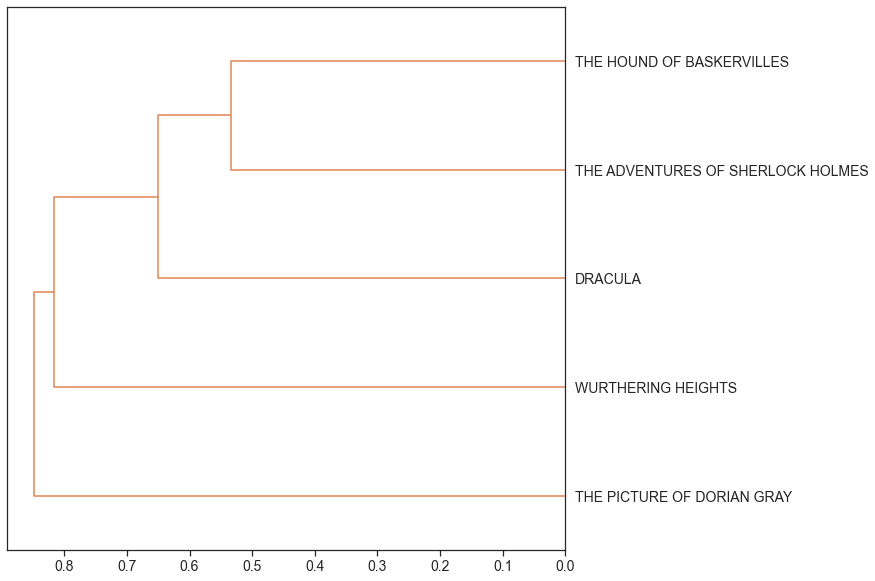

In [98]:
hac(PAIRS.cosine, linkage_method='ward', color_thresh=1.2)

<Figure size 432x288 with 0 Axes>

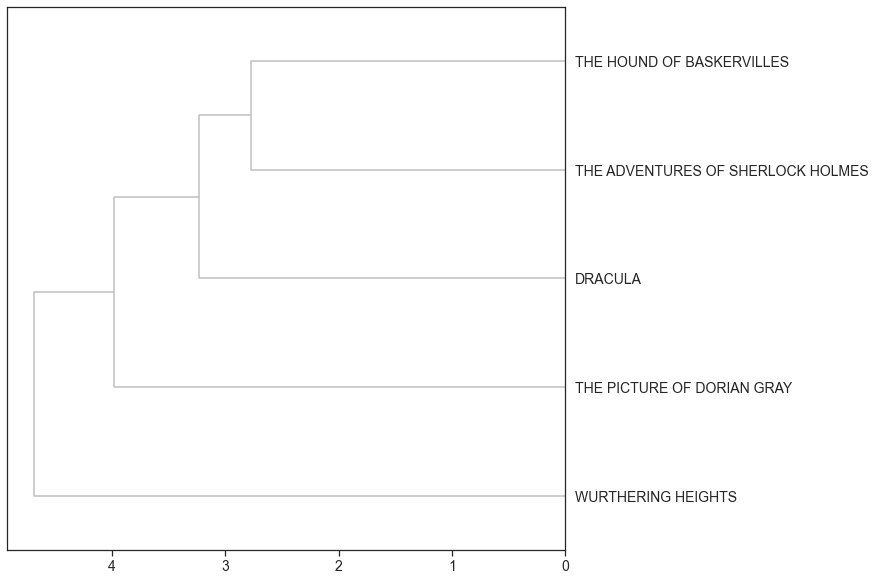

In [99]:
hac(PAIRS.cityblock, linkage_method='weighted', color_thresh=1.2)

<Figure size 432x288 with 0 Axes>

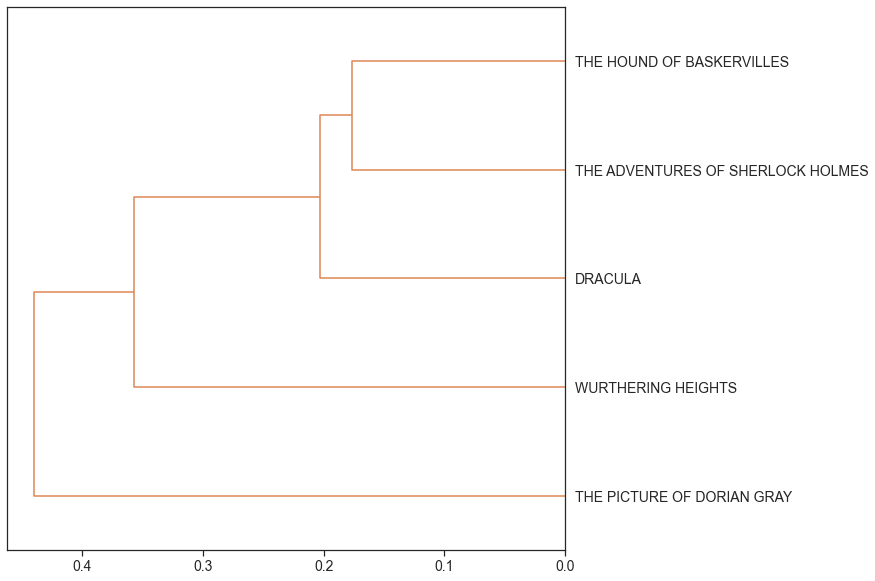

In [100]:
hac(PAIRS.euclidean, linkage_method='ward', color_thresh=1.2)

<Figure size 432x288 with 0 Axes>

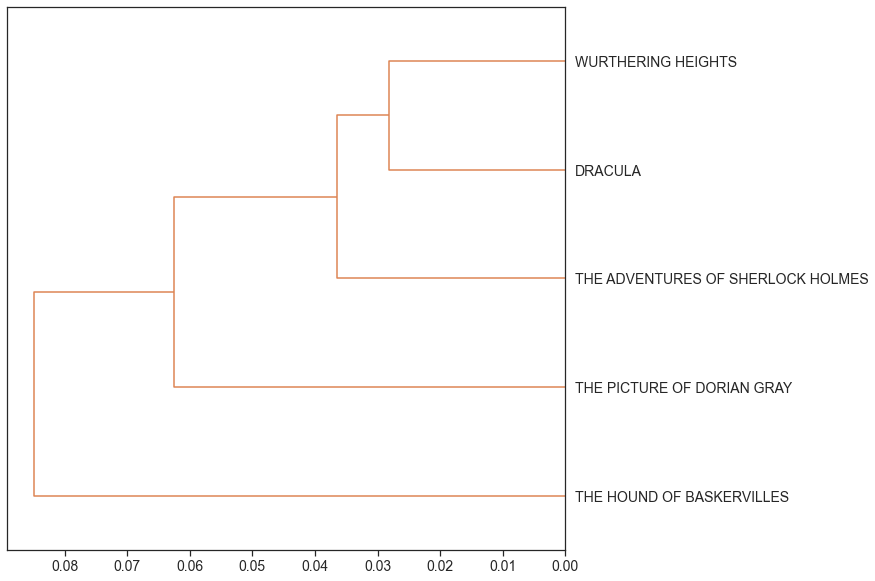

In [101]:
hac(PAIRS.jaccard, linkage_method='weighted', color_thresh=1.2)

<Figure size 432x288 with 0 Axes>

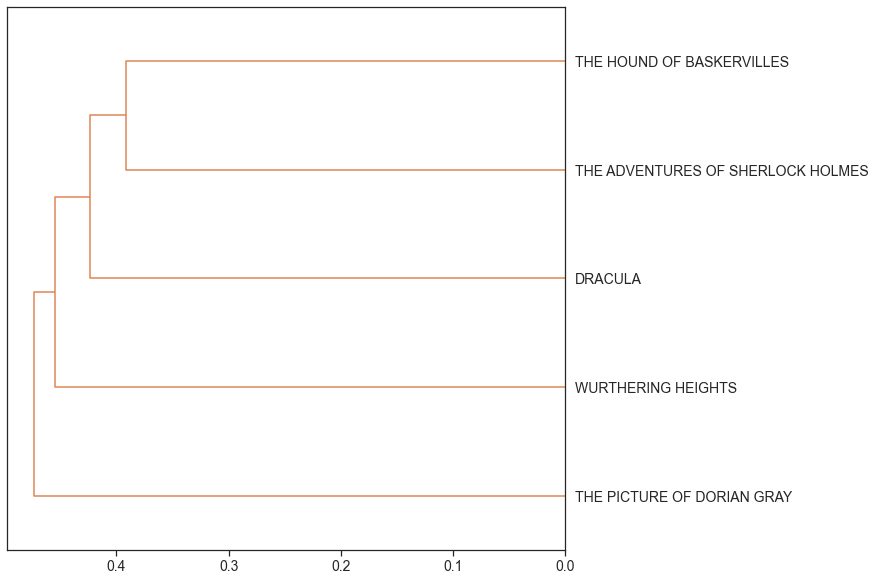

In [102]:
hac(PAIRS.js, linkage_method='weighted', color_thresh=1.2)